In [42]:
import pandas as pd
import subprocess
import os
from rs3.seq import predict_seq
import time
from scipy.stats import norm



In [ ]:
class Args:
    threads = "6"
    mismatches = "5"
    #altpams = NAG
    kmers = "./"
    ouput= ""
    

In [ ]:
os.chdir("./crispomics/")

In [2]:
!ls

filtered_file.csv	   launch.json		SPI1.gff3.db
FilterKmerBED		   out.bed		stdout
finalKmers.bed		   out.gff3		test
GenerateKmerBED		   output.gff3		tmp
gscan.csv		   ProcessAnnotation	trimmedAnnotation.gff
guideScanOut_complete.csv  README.md		trimmed.gtf
guideScanOut.csv	   ScoringGuides.ipynb
kmers.bed		   SPI1.gff3


In [2]:
def guideScanScoring(guideCSV, guideIndex, threads = 2, mismatches = 4):
    tempOutput = './tmp/guideScanOut.csv'
    cmd = [
        'guidescan',
        'enumerate',
        '--max-off-targets',
        '-1',
        '--threads',
        str(threads),
        '--mismatches',
        str(mismatches),
        '--format',
        'csv',
        '--mode',
        'succinct',
        '--kmers-file',
        guideCSV,
        '--output',
        tempOutput,
        guideIndex
    ]

    subprocess.run(cmd, check=True)

    # read the csv file
    gscanDF = pd.read_csv(tempOutput)

    # drop duplicate rows and keep the first occurrence
    gscanDF = gscanDF.drop_duplicates(subset='id', keep='first')

    # write the result to a new csv file
    return gscanDF

In [3]:
def cleavageScoring(kmers, minPercentile = 0.40, tracr = 'Hsu2013', threads = 2):
#start_time = time.time()
    kmerDF = pd.read_csv(kmers, delimiter='\t', \
                         header=0 )
    # guideScores = predict_seq(sgRNAlist, sequence_tracr='Hsu2013', n_jobs=12)

    sgRNAlist = kmerDF['context'].tolist() # 1709 seconds chr21, 12 cores 
    # test
    #kmerDF = kmerDF.head(10005)

    # process the list in chunks to reduce memory footprint
    chunk_size = 100000

    sgRNAScores = []

    # Iterate over big_list in chunks of size chunk_size
    for i in range(0, len(sgRNAlist), chunk_size):
        sublist = sgRNAlist[i:i + chunk_size]
        processed_sublist = predict_seq(sublist, sequence_tracr=tracr, n_jobs=threads)
        sgRNAScores.extend(processed_sublist)

    kmerDF['rs3_z_score'] = sgRNAScores
    kmerDF['rs3_percentile'] = norm.cdf(kmerDF['rs3_z_score'])
    kmerDF['rs3_score_norm'] = (kmerDF['rs3_z_score'] - kmerDF['rs3_z_score'].min()) / (kmerDF['rs3_z_score'].max() - kmerDF['rs3_z_score'].min())
    #kmerDF = kmerDF[kmerDF['rs3_percentile'] > minPercentile]

    kmerDF['id'] = kmerDF['id,sequence,pam,chromosome,position,sense'].str.split(',').str[0]

    return kmerDF


#    end_time = time.time()

In [ ]:
def plotScores()

In [36]:
!pwd

/home/eric/Projects/CrisprLibrary/crispomics


In [53]:
rs3Weight, gscanWeight = 0.67 , 0.33
kmersPerTscript = 10
minSpecificity = 0.5
minRS3 = 0.5

kmerDF = cleavageScoring(kmers = './tmp/loc_filtered_guides.tsv', minPercentile = 0.00)

gscanTMPFile = './tmp/scored_guides_for_guidescan.csv'

kmerDF[['id,sequence,pam,chromosome,position,sense']].to_csv(gscanTMPFile, sep='\t', index=False)
gscanDF = guideScanScoring(guideCSV = gscanTMPFile, guideIndex = '../chr21Index/chr21.fa.index', threads = 2, mismatches = 4)

kmerDF = kmerDF.merge(gscanDF[['id', 'specificity']], on='id', )

kmerDF['combined_score'] = rs3Weight * kmerDF['rs3_score_norm'] + gscanWeight * kmerDF['specificity'] 

kmerDF.sort_values(by='combined_score', inplace=True, ascending=False)

'''
reducedKmerDF = kmerDF.assign(tscripts=kmerDF['tscripts'].str.split(',')).explode('tscripts')

# Step 2: Sort by "combined_score" within each transcript
reducedKmerDF.sort_values(['tscripts', 'combined_score'], ascending=[True, False], inplace=True)

# Step 3: Keep only the top 10 entries per transcript
reducedKmerDF = reducedKmerDF.groupby('tscripts').head(kmersPerTscript)

cols = reducedKmerDF.columns.tolist()  # get a list of all columns
cols.remove('tscripts')  # remove 'tscripts' from this list

finalKmerDF = reducedKmerDF.groupby(cols, as_index=False)['tscripts'].apply(','.join).reset_index()
'''

Calculating sequence-based features


100%|██████████████████████████████████████████| 89/89 [00:00<00:00, 155.83it/s]


[2023-08-01 16:08:17.414] [guidescan2] [info] Loading genome index at "../chr21Index/chr21.fa.index".
[2023-08-01 16:08:17.496] [guidescan2] [info] Successfully loaded genome index.
[2023-08-01 16:08:17.496] [guidescan2] [info] Loading kmers.
[2023-08-01 16:08:17.497] [guidescan2] [info] Read in 89 kmer(s).
[2023-08-01 16:08:19.346] [guidescan2] [info] Processed 89 kmers in 1 seconds.


'\nreducedKmerDF = kmerDF.assign(tscripts=kmerDF[\'tscripts\'].str.split(\',\')).explode(\'tscripts\')\n\n# Step 2: Sort by "combined_score" within each transcript\nreducedKmerDF.sort_values([\'tscripts\', \'combined_score\'], ascending=[True, False], inplace=True)\n\n# Step 3: Keep only the top 10 entries per transcript\nreducedKmerDF = reducedKmerDF.groupby(\'tscripts\').head(kmersPerTscript)\n\ncols = reducedKmerDF.columns.tolist()  # get a list of all columns\ncols.remove(\'tscripts\')  # remove \'tscripts\' from this list\n\nfinalKmerDF = reducedKmerDF.groupby(cols, as_index=False)[\'tscripts\'].apply(\',\'.join).reset_index()\n'

<Axes: ylabel='Frequency'>

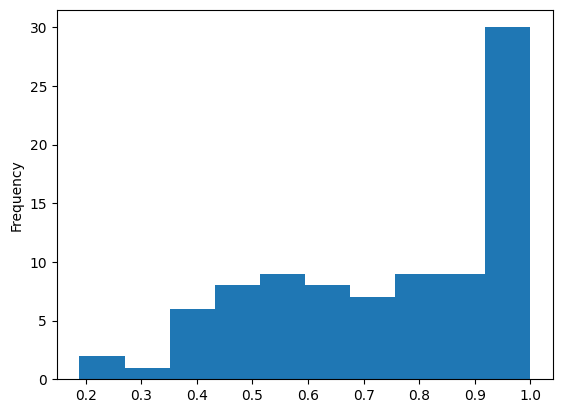

In [13]:
kmerDF['specificity'].plot.hist()


<Axes: ylabel='Frequency'>

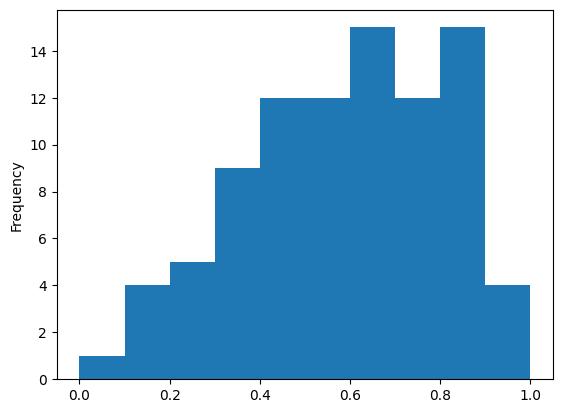

In [22]:
kmerDF['rs3_score_norm'].plot.hist()


In [54]:
kmerDF

,chr,start,stop,"id,sequence,pam,chromosome,position,sense",context,strand,tscripts,id,rs3_z_score,rs3_percentile,rs3_score_norm,specificity,combined_score
65,chr21,21338521,21338522,"chr21:21338505:+,GATGGCTTCACGTTCACTGA,NGG,chr2...",CTGTGGATGGCTTCACGTTCACTGAAGGCG,+,"ENST00000400546.6,ENST00000284894.8",chr21:21338505:+,1.142982,0.873477,1.000000,1.000000,1.000000
68,chr21,21373867,21373868,"chr21:21373851:+,CGATGTAAACAGAGCCTGGA,NGG,chr2...",TGAATCGATGTAAACAGAGCCTGGACGGCC,+,"ENST00000400546.6,ENST00000284894.8",chr21:21373851:+,0.849544,0.802211,0.916182,1.000000,0.943842
8,chr21,20998593,20998594,"chr21:20998587:-,TACTGACAAGCAACCCCAGC,NGG,chr2...",CCCGCTACTGACAAGCAACCCCAGCAGGTA,-,ENST00000400546.6,chr21:20998587:-,0.752817,0.774220,0.888553,1.000000,0.925331
58,chr21,21338462,21338463,"chr21:21338446:+,CACTCGTATGTGATGCGGAA,NGG,chr2...",AGTCACACTCGTATGTGATGCGGAAGGGGA,+,"ENST00000400546.6,ENST00000284894.8",chr21:21338446:+,0.731061,0.767629,0.882338,1.000000,0.921167
70,chr21,21373885,21373886,"chr21:21373869:+,GACGGCCGTATCGAAGTCAA,NGG,chr2...",GCCTGGACGGCCGTATCGAAGTCAAAGGGC,+,"ENST00000400546.6,ENST00000284894.8",chr21:21373869:+,0.456342,0.675928,0.803868,1.000000,0.868591
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,chr21,21324457,21324458,"chr21:21324441:+,AGAAATGACATTTTCCTGCA,NGG,chr2...",GGAGAAGAAATGACATTTTCCTGCAGGGCC,+,"ENST00000400546.6,ENST00000284894.8",chr21:21324441:+,-1.648592,0.049616,0.202612,0.723053,0.374358
85,chr21,21410312,21410313,"chr21:21410296:+,CCAAACAATTTATTACTCTT,NGG,chr2...",TCAAACCAAACAATTTATTACTCTTGGGAA,+,"ENST00000400546.6,ENST00000284894.8",chr21:21410296:+,-1.951867,0.025477,0.115984,0.837609,0.354120
62,chr21,21338484,21338485,"chr21:21338478:-,GCTCTTTTCCAAGTGATTTC,NGG,chr2...",CCACAGCTCTTTTCCAAGTGATTTCTGGAA,-,"ENST00000400546.6,ENST00000284894.8",chr21:21338478:-,-2.357916,0.009189,0.000000,0.959700,0.316701
54,chr21,21338400,21338401,"chr21:21338394:-,TTTTTAAGCTGTATTATGTG,NGG,chr2...",TTTCATTTTTAAGCTGTATTATGTGAGGCT,-,"ENST00000400546.6,ENST00000284894.8",chr21:21338394:-,-1.864194,0.031147,0.141027,0.418275,0.232519
